In [35]:
#loss = bias + variance + noise
#use for regression perfomance measure

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cuml.manifold import TSNE

In [37]:
trainDF = pd.read_csv('../app/data/02_train.csv', sep=';')
testDF = pd.read_csv('../app/data/02_test.csv', sep=';')

In [38]:
X_train = trainDF.drop(['totalPrice'], axis=1)
y_train = trainDF['totalPrice']
X_test = testDF.drop(['totalPrice'], axis=1)
y_test = testDF['totalPrice']

In [39]:
X_train

,floorType,floor,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,...,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,tradeYear,tradeMonth,tradeDay,constructionTimePeriod
0,84113,6,116.474283,39.930035,51.82,2,1,1,1,120872,...,0.250,0.0,1.0,1.0,7,67222.0,2015,10,9,16727
1,84113,32,116.416156,40.082585,97.78,2,1,1,1,59076,...,0.375,1.0,0.0,1.0,6,33820.0,2011,11,13,139258
2,44810,6,116.520858,39.918846,61.13,2,1,1,1,120872,...,0.333,0.0,1.0,1.0,7,56752.0,2015,4,12,13522
3,44810,6,116.350909,39.745849,62.82,2,1,1,1,120872,...,0.333,0.0,1.0,0.0,4,38492.0,2014,8,24,13522
4,49078,6,116.351933,39.887523,68.89,2,1,1,1,120872,...,0.500,0.0,1.0,0.0,10,87885.0,2016,2,2,139258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223166,84113,13,116.416187,39.969551,119.16,2,2,1,1,41709,...,0.143,1.0,1.0,0.0,1,92338.0,2013,1,4,139258
223167,84113,7,116.298972,39.943157,119.07,2,2,1,2,120872,...,0.500,1.0,1.0,1.0,8,87420.0,2016,5,9,139258
223168,26053,13,116.440460,39.860650,120.14,3,1,1,2,120872,...,0.500,1.0,1.0,0.0,2,57690.0,2016,4,30,52909
223169,49078,19,116.368316,39.892214,74.61,2,1,1,1,59076,...,0.250,1.0,1.0,1.0,10,75806.0,2014,4,28,139258


In [40]:
embedded = TSNE(n_components = 2).fit_transform(X_train[['buildingType', 'constructionTimePeriod', 'tradeYear', 'square']])

/home/glatzlandre@edu.local/anaconda3/envs/ml/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [09:44:37.296776] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


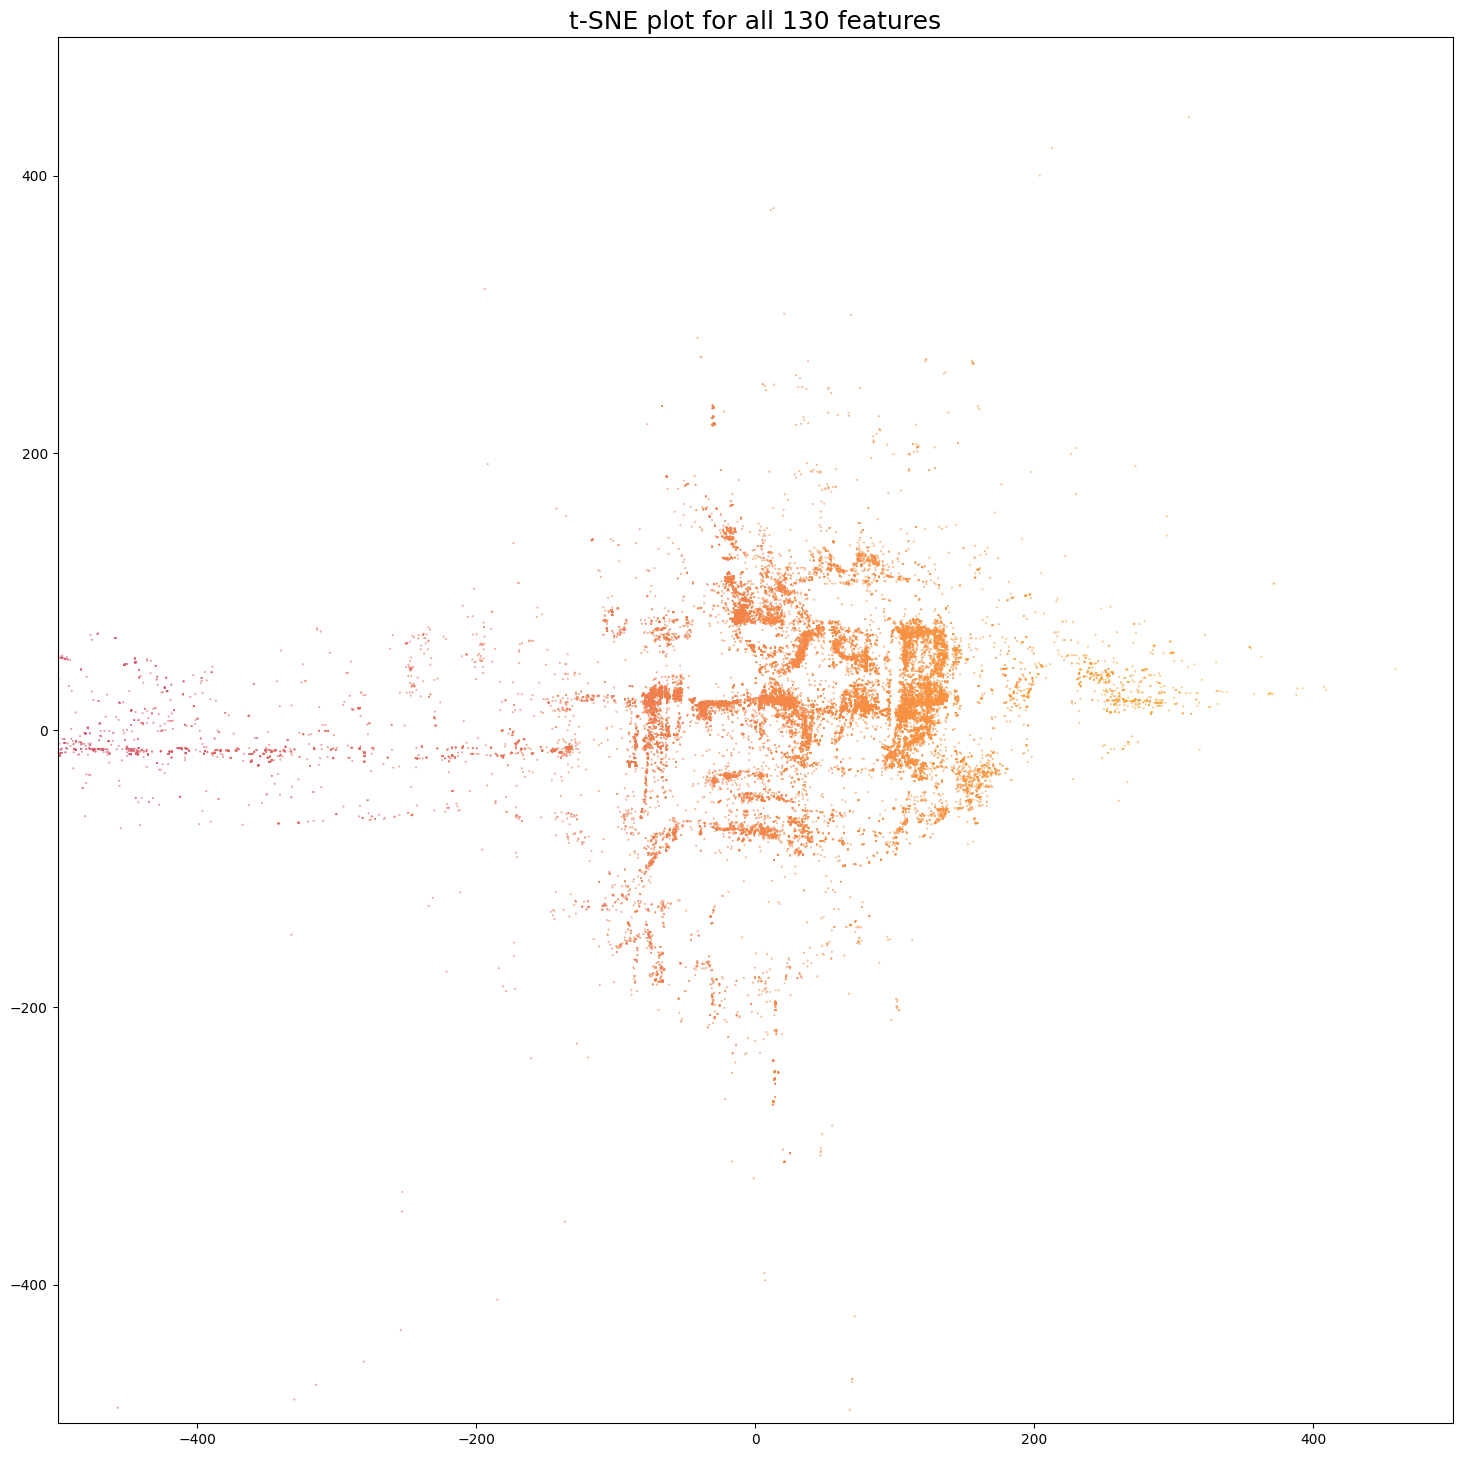

In [41]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(embedded[:,0], embedded[:,1], s=0.1, c=embedded[:,0], cmap=plt.cm.plasma)
ax.set_title('t-SNE plot for all 130 features', fontsize=18)
plt.xlim([-500, 500])
plt.ylim([-500, 500])
plt.show();